# Random Forest Model interpretation

REFERENCES:
- [ML Lesson2 Fastai Notebook](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb)
- [Hiromi Suenaga Notes (Partial)](https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-3-fa4065d8cb1e)
- [Class video](https://youtu.be/YSFG_W8JxBo)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

#from fastai.imports import *
#from fastai.structured import *
import pandas as pd
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
from fastai.structured import set_plot_sizes, proc_df
set_plot_sizes(12,14,16)   # set_plot_sizes(sml, med, big)  from fastai.structured

## Load in data from ML1-RF (last lesson + preliminaries)
We start by reading the feather file for Blue Books for Bulldozers competition. 
Previously we read the CSV, processed it into categories, and saved it in feather format. 
Next, call `proc_df` to turn categories into integers, deal with missing values, and pull out the dependent variable. Then create a validation set of 12000 rows.

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print("RMSE Train\t\t RMSE Valid\t\tR2 train\t\tR2 valid\t OOB\n", res)

Below, `SalePrice` is the log of the sale price.

In [7]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


# Confidence based on tree variance

We know how to get predictions: run a row through the RF: take the average value in each leaf node in each tree. <br> 
We also want to know how **confident** we are of that prediction.<br>
Our confidence on a prediction relates to how many examples of similar rows we have seen. 
As we pass an "unusual" row through different trees, it will end up in different places. 

For model interpretation, there is no need to use the full dataset, 
we do not need an accurate RF, just one which indicates the nature of the relationships involved.
Using a subset is faster, and provides better interpretability, 
since an overfit model will not provide much variance across trees. <br>
We invoke `set_rf_samples()` with a parameter that is *good enough*, and small enough to run fast (< 10 sec).<br>
**NB:** sample size should be **large enough** that if we call the same interpretation commands multiple times, 
we do not get different results back each time. 
50,000 (**per-tree**) is a sufficiently high number and runs in seconds. 

In [8]:
from fastai.structured import set_rf_samples, reset_rf_samples
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 36.9 s, sys: 1.1 s, total: 38 s
Wall time: 9.19 s
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20580984320731832, 0.24996954840886612, 0.9114747606438984, 0.8884107945646509, 0.8944916623199729]


The model averages predictions across the trees to get an estimate.
To assess the confidence of the estimate we use `std()` of predictions, instead of just the mean. 
This tells us the **relative** confidence of predictions. If `std()` is high, 
each tree is giving a different estimate of this row’s prediction. 
If this was a common row, the trees would have learned to make good predictions for it, 
because they had opportunities to split based on those kind of rows.
We want to be more cautious using those results, compared to cases where they are more consistent. 
The `std()` of the predictions across the trees gives us a relative understanding of how confident 
we are of this prediction ML3 [56:39]. 

In [10]:
import numpy as np

In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,1]), np.std(preds[:,1])   #for one observation, the mean and the std

CPU times: user 1.24 s, sys: 40 ms, total: 1.28 s
Wall time: 1.28 s


(9.301638547545746, 0.24436613296702636)

Above we have the prediction and the standard deviation of a single row.

Python (above in the comprehension) will loop through trees calculating each tree serially, which is **slow!** 
We use parallel processing to speed this computation:
`parallel_trees` applies the function `get_preds` on $m$ (the RF model) in parallel to every tree, and returns a list. (Default `n_jobs=8`)

In [12]:
from fastai.structured import parallel_trees
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,1]), np.std(preds[:,1])

CPU times: user 93.7 ms, sys: 100 ms, total: 194 ms
Wall time: 397 ms


(9.301638547545746, 0.24436613296702636)

Clearly, (as std>0.2 ?), different trees are giving different estimates for the same auction price (row [1]). 
To see how the prediction confidence varies, we add columns for both the deviation and prediction.  

In [13]:
x = raw_valid.copy()   #make x a copy of the raw valid data
x['pred_std'] = np.std(preds, axis=0)  #add column `pred_std` for predicted standard deviation
x['pred'] = np.mean(preds, axis=0) #add a column `pred` for the mean

In [14]:
x.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,pred_std,pred
389125,4364751,9.104980,2300944,665,172,1.0,1999,3726.0,Low,KX1212,...,259,False,False,False,False,False,False,1284595200,0.334507,9.319179
389126,4364757,9.047821,1265434,12042,172,1.0,1996,5809.0,Low,KX151,...,343,False,False,False,False,False,False,1291852800,0.244366,9.301639
389127,4364774,9.104980,2005935,9218,172,1.0,1993,0.0,NaN,KX41,...,218,False,False,False,False,False,False,1281052800,0.133480,9.134341
389128,4364807,9.259131,2296707,668,172,1.0,2000,1789.0,Low,KX612,...,349,False,False,False,False,False,False,1292371200,0.388301,9.300020
389129,4364811,9.104980,1403366,9219,172,1.0,1999,0.0,NaN,KX61,...,161,False,False,False,False,False,False,1244592000,0.122736,9.109509


### Examining a variable as a predictor
Lets examine a single variable (eg `Enclosure`) as a predictor, and do a histogram to see which values of this variable matter

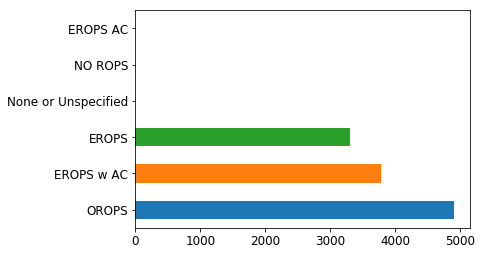

In [15]:
x.Enclosure.value_counts().plot.barh(); 

Q: What is `Enclosure`? [01:02:50]? Do not know what it means and it does not matter. 
First we learn what things are important and later what they are and how they are important. 
We started out knowing nothing about this dataset, we will look at the variable `Enclosure`, 
but we do not know what `Enclosure` is.
We see that only 3 values appear: `OROPS, EROPS w AC`, and `EROPS`. <br>

Data scientists look at unfamiliar data and must figure out which bits to study more carefully.
Now we do not care about `EROPS AC`, `NO ROPS`, and `None or Unspecified`, as they basically do not exist. 
We will focus on `OROPS`, `EROPS w AC`, and `EROPS`.

Now lets select 4 fields for a new dataframe view, `enc_summ`: `Enclosure`, `SalePrice`, `pred`, `pred_std`.
In the view we `groupby` `Enclosure`, and compute the mean of the 3 other columns.

In [16]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.836172,0.273829
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.575339,0.267999
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.687792,0.222452


We can learn a bit from these, e.g., the `SalePrice` is close to the prediction (here the median?) <br>
Now select the rows in the df that have `SalePrice` values to plot (ie `~pd.isnull(enc_summ.SalePrice)`), and then plot the actual SalePrice.

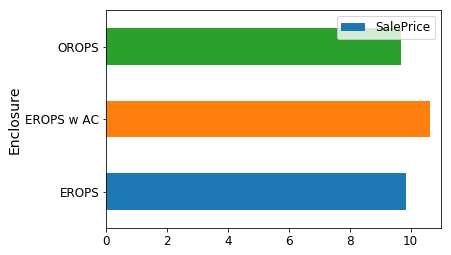

In [17]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)] 
enc_summ.plot(x='Enclosure', y='SalePrice', kind='barh', xlim=(0,11)); #barh indicates horizontal bars and label

Now the equivalent graph for the predictions, and the `xerr=` shown as a black line for the standard deviation.  What is the parameter `alpha` ?  Not defined in `plot`

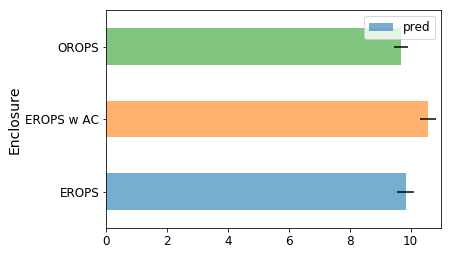

In [18]:
enc_summ.plot(x='Enclosure', y='pred', kind='barh', xerr='pred_std', alpha=0.6, xlim=(0,11)); 

We used the standard deviation of prediction for the error bars above. This will tell us if there is some groups or some rows that we are not confident of at all. 

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

### Examining another variable as a predictor
Lets do something similar for `ProductSize`.

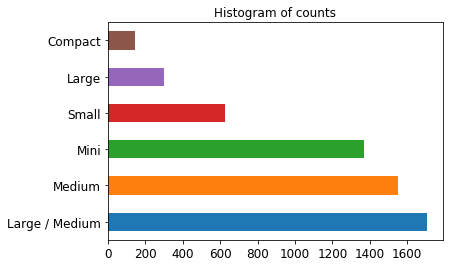

In [19]:
raw_valid.ProductSize.value_counts().plot.barh(title="Histogram of counts"); 

In [20]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby('ProductSize', as_index=False).mean()
summ

,ProductSize,SalePrice,pred,pred_std
0,Compact,9.735093,9.862829,0.361706
1,Large,10.470589,10.392188,0.363518
2,Large / Medium,10.691871,10.642673,0.299881
3,Medium,10.681511,10.623213,0.288133
4,Mini,9.535147,9.555064,0.254569
5,Small,10.324448,10.327526,0.315625


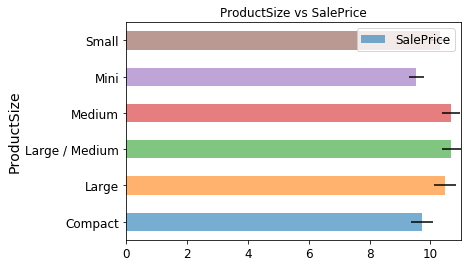

In [21]:
summ.plot(x='ProductSize', y='SalePrice', kind='barh', xlim=(0,11), 
          xerr='pred_std', alpha=0.6, title="ProductSize vs SalePrice");

We expect, on average, when we predict something that is a bigger number, the  standard deviation would be higher. 
So we sort by the ratio of the standard deviation of the predictions to the predictions themselves [1:05:51].
`summ.pred_std/summ.pred`

In [22]:
(summ.pred_std/summ.pred).sort_values(ascending=False)   #sort by ratio

0    0.036674
1    0.034980
5    0.030562
2    0.028177
3    0.027123
4    0.026642
dtype: float64

The above sorted list shows that for `Compact` and `Large` we have less confidence, and that is because we have seen fewer of those, as shown by the histogram of counts above.<br>
Confidence interval is used for 2 main purposes:
- by group to find out if there are groups we do not have confidence about.
- for specific rows.

In production, we may want to see the confidence interval, 
e.g. for credit scoring, to decide whether to give somebody a loan, and how big, etc. 

# Feature importance

It's not enough to know that a model can make accurate predictions - we also want to know **how** it's making predictions. The most important way to see this is with **feature importance**.  That is, what features (columns) matter. JH always looks at this first.

`rf_feat_importance` (from fastai library) computes the "feature importance" given a model and the corresponding DF.
It builds a RF, then **randomly shuffles a single column (variable) at a time**. 
Then computes (on the same RF, without retraining) to get new predictions (after shuffling the variable).
Compare the new predictions with the originals, and see how much worse the model predictions got after doing the re-shuffle.
Start building a *little table* to compare the relative importance, i.e.,
the bigger the difference on the predicted variable, the bigger the importance of a variable.
<br>
**NB:** Anecdote: Sometimes, the most important variable is **hugely** more important, 
relatively to the others, e.g., 1000 times more important...
But that is because it was a mistake (e.g., the variable was a different encoding of the dependent variable).
Alos, it could be that truly it is more important, and hence we need to focus on it.

`rf_feat_importance` takes a model `m` and dataframe `df_trn` (because we need to know names of columns) and 
returns a Pandas dataframe showing how important each column was.

In [23]:
from fastai.structured import rf_feat_importance
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.171207
37,Coupler_System,0.108882
13,ProductSize,0.089518
14,fiProductClassDesc,0.084630
2,ModelID,0.053467
63,saleElapsed,0.049744
39,Hydraulics_Flow,0.049684
10,fiSecondaryDesc,0.045154
19,Enclosure,0.043070
12,fiModelDescriptor,0.033728


So, `YearMade`, `CouplerSystem`, and `ProductSize` are the top 3.

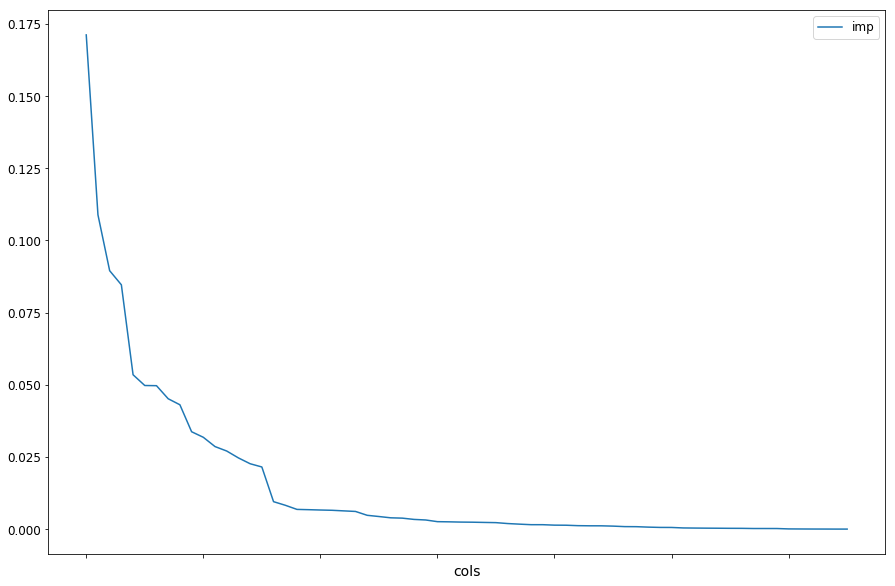

In [24]:
fi.plot('cols', 'imp', figsize=(15,10), legend=False);

Some columns are important and most columns do not matter at all. 
In most real-life datasets, this is how feature importance looks like. 
There are only a few columns to care about, so always start here. 
For this domain (heavy industrial equipment auctions), we learn about a variable, e.g. `Enclosure`,
only if `Enclosure` is important. 
Since it appears in top 10, we will. 

In [25]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

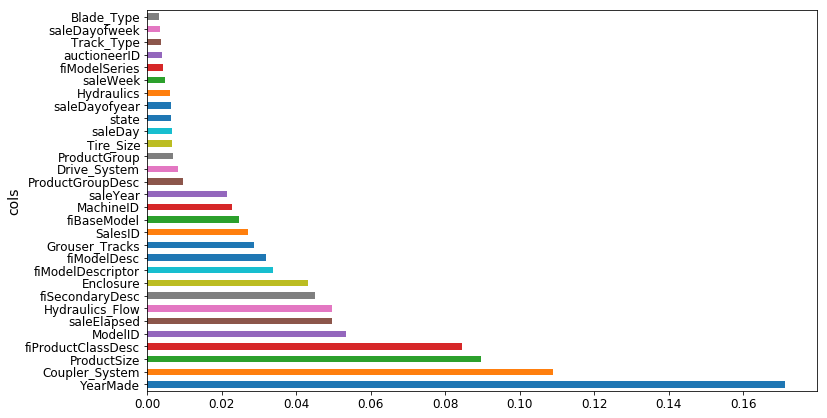

In [26]:
plot_fi(fi[:30]);

Now, sit (with client, data dictionary, or whatever source), and ask about, eg `YearMade`. 
What does it mean? Where does it come from?” [1:10:31] 
Make plots, like histogram of `YearMade` and scatter plot of `YearMade` against price, etc.
We want to learn everything we can because `YearMade` and `Coupler_System` matter.

Often in real-world projects, we sit with the client and say 
*“it turns out the Coupler_System is the second most important thing”*
and they say *“that makes no sense.”* 
That doesn’t mean that there is a problem with the model.
It means there is a problem with their understanding of the data they gave you.

We often find **data leakage** problems, that is a serious issue to deal with [1:12:56]. 
We also often find signs of **collinearity**. 
It seems like what happened with `Coupler_System`, which tells if a bulldozer type has a particular feature on it. 
But if it is not that kind of bulldozer, it will be missing. 
So `Coupler_System` indicates whether or not it is a certain class of equipment. 
This is not data leakage.
It is information we have at the right time, and must be careful interpreting it. 
We should go through at least the top 10 (or a natural break point) and study them carefully.

### Throw away some data
It is sometimes good to *"throw some data away"* and see if it make any difference. 
Here we have a RF which was .889 $R^2$ for validation set. 
Below we filter out those columns where the importance is $\le$ 0.005 (i.e. only keep importance > 0.005).

In [27]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)   #keep only those columns that are more significant than .005

24

We create:
- a new DF, `df_keep` with the columns where importance value is greater than 0.005. 
- new train and validation set with just those columns.
- new RF 

and see how the validation set score and the validation set RMSE changed.

In [28]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [29]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20737142498381375, 0.24601589652132735, 0.9101262940791862, 0.8919127880489913, 0.8936911654655694]


$R^2$ valid did not change much — it actually increased a bit. 
Generally, removing redundant columns should not make $R^2$ worse. 
If it makes it worse, they were not redundant. 
It might make better because it has fewer things to try, less often will accidentally find a crappy column. 
There is slightly better opportunity to create a better tree with less data, 
but it is not going to change it by much. 
But it is faster, and will let us focus on what matters. 
Let’s re-run feature importance on this new result [1:15:49].

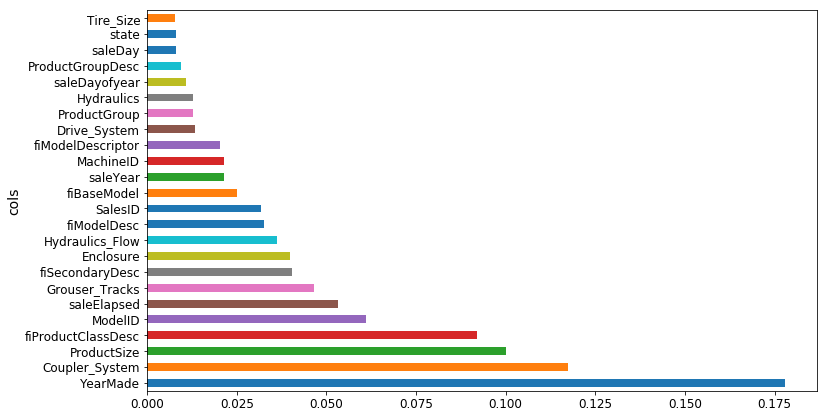

In [30]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

When we remove redundant columns, we remove sources of collinearity, ie columns that might be related to each other. Collinearity does not make your RFs less predictive.
But if column A is a little bit related to column B, and B is a strong driver of the independent, 
the importance is split between A and B. 
By removing columns with little impact, it makes the feature importance plot clearer. 
Before `YearMade` was closer in importance to `Coupler_System`. 
There must have been a few columns collinear with `YearMade`, and now we see that `YearMade` is more important. 
This feature importance plot is more reliable than the earlier because it has less collinearity to confuse us.

We've got a model which isn't better as a predictive accuracy wise,
but it's giving a good sense that there seems to be 4 important variables:
`YearMade, Coupler_System, ProductSize`, and `fiProductClassDesc`.

#### Review of `YearMade`

- what is the histogram of `YearMade`?

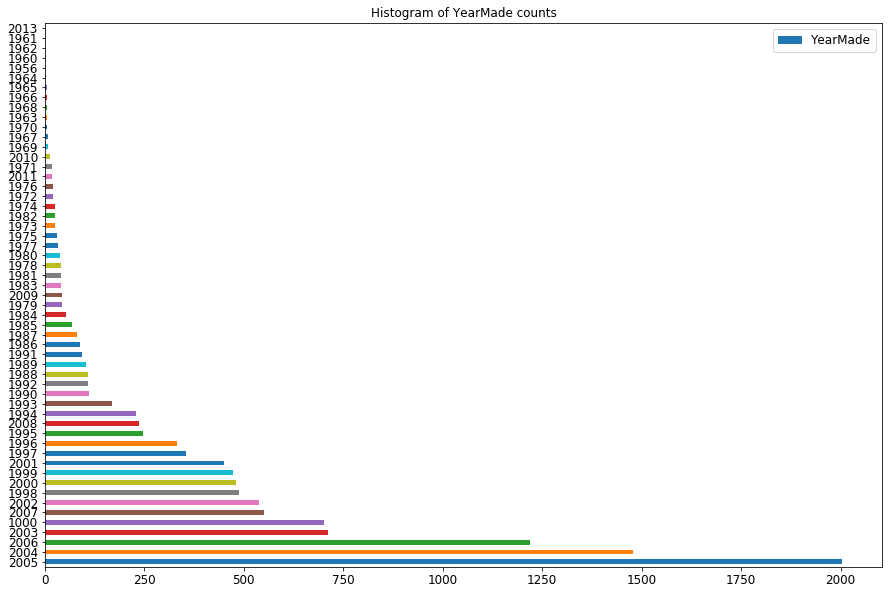

In [31]:
x.YearMade.value_counts().plot.barh(title="Histogram of YearMade counts",figsize=(15,10), legend=True); 

 what is the relationship between `YearMade` and the dependent variable `SalePrice` ?

In [32]:
flds = ['YearMade', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby('YearMade', as_index=False).mean()
summ.head()

,YearMade,SalePrice,pred,pred_std
0,1000,9.769063,9.688327,0.360764
1,1956,8.987197,9.296185,0.276958
2,1960,9.325896,9.450706,0.344156
3,1961,9.132379,9.525754,0.396576
4,1962,9.104980,9.537511,0.363454


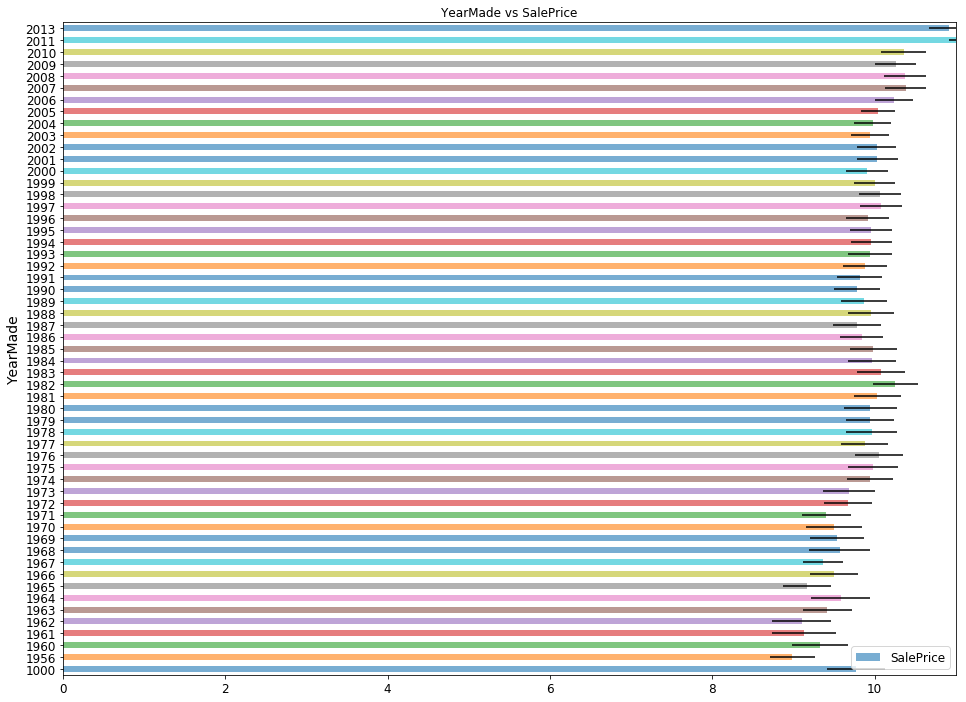

In [33]:
summ.plot(x='YearMade', y='SalePrice', kind='barh', xlim=(0,11), figsize=(16,12),
          xerr='pred_std', alpha=0.6, title="YearMade vs SalePrice");

We now have a more accurate model and we learned a lot more about it. 
**TODO:** go through the top 5-10 predictors, draw plots in Pandas and get insights about things like:
- Is there some noise in YearMade which we could fix
- Check if there is some weird encoding in that column we can fix
- Is `Coupler_System` collinear with something else? 
- `fiProductClassDesc` sounds like it might be a high cardinality categorical variable. 
    - It might be something with many levels because it sounds like it is a model name. 
    - Look at that model name — does it have some order into it? 
    - Could we make it an ordinal variable to make it better? 
    - Does it have some hierarchical structure in the string that we can split it on hyphen to create more sub columns.

## One-hot encoding

Provide the RF the ability to discriminate in a way that it may improve the trees. For example, by noticing a particular value of a category in a single step, faster,  e.g. if it is or not a given value, the value unknown.  It may (or not) improve the RF. <br>

`max_n_cat` defines the maximum number of categories to break into dummy values, instead
    of integer codes.

In [34]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20737610638355358, 0.25374943851827875, 0.9101222362443848, 0.8850105083930436, 0.8923289906622442]


`proc_df` names the dummy valuables as *originalname_value*, e.g. `ProductSize_Compact`.
<br>
**NB:** Sometimes the importance of the variable changes when it is hot-encoded.
For interpreting a model we should try one hot encoding,
making `max_n_cat` as high as we can so that it doesn't take too long to compute.

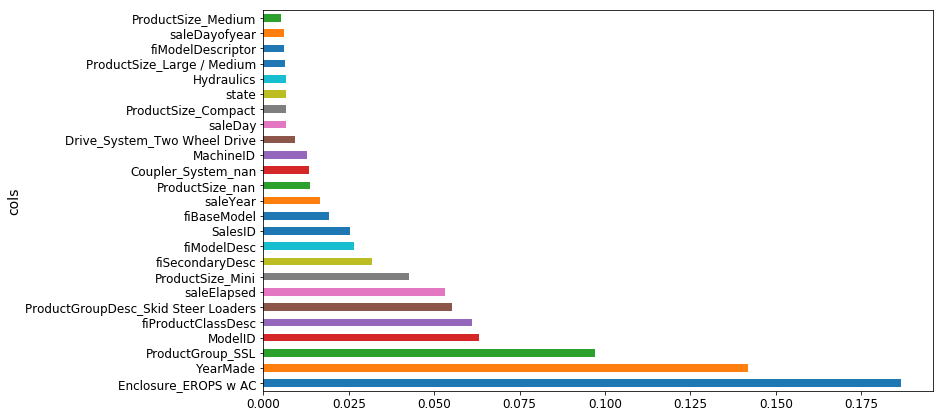

In [35]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

Feature importance doesn't include tiny levels that aren't interesting.
What is `Enclosure_EROPS with AC` and why is it important?

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

[Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) 
was a popular technique 20+ years ago.
"Agglomerated clustering" is the "bottom-up" approach, "Divisive" is the top-down.
In hierarchical we look at every pair of objects.
The two objects that are the closest we delete and replace with the midpoint of the two.
We repeat removing points and replacing them with their averages, 
gradually reducing the number of points by pairwise combining.
We plot so rather than looking at points we look at which 2 variables are the most similar.

In [36]:
import scipy
from scipy.cluster import hierarchy as hc
from matplotlib import pyplot as plt

Once we've got a correlation matrix there's basically a couple of
standard steps to turn that into a [dendogram](https://en.wikipedia.org/wiki/Dendrogram), listed below.

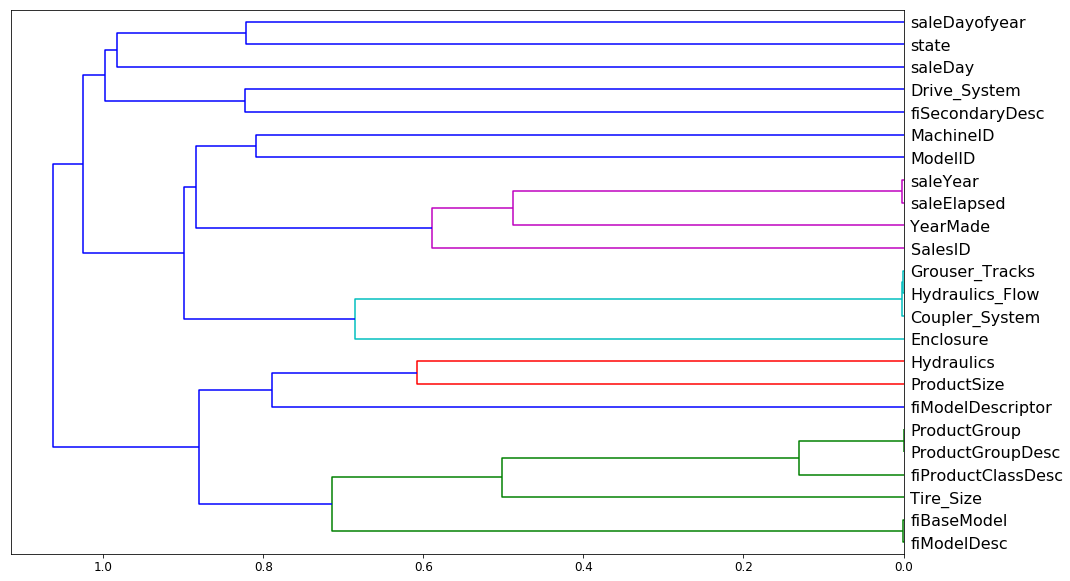

In [37]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

The horizontal axis here is how similar are the two points that are being compared.
If they're closer to the right, it means they're very similar.<br>
We combine `saleYear` and `saleElapsed` as they are very similar. <br>
Units would be correlation coefficient, in this case we used Spearman's R (rank).
<br>
There are 4 pairs of variables (e.g. `Hydraulics_Flow` and `Grouser_Tracks`), 
that are highly correlated, according to the above dendogram.
Everything else is further away so we are not going to worry about those.
<br>
We try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [38]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

`get_oob(df)` returns the score of a RF for some data frame.
We take the data frame and split it into a training and validation
set and then call fit and return the OOB score.
We are going to try removing some variables, one at a time, 
and see which ones we can remove without making the OOB score get worse.
Each time we run this we get slightly different results.

Here's the baseline for accuracy using the OOB score on the whole df.

In [39]:
get_oob(df_keep)

0.8903648042866782

Now we try removing each variable one at a time.
We loop through each of the variables that we think we could get rid of
and print the name and the OOB score.
The base OOB score is above .889.
After dropping each one of these columns none of them gets a much worse OOB.
`saleElapsed` is getting quite a bit worse than `saleyear`,
but everything else we can drop with a third decimal place.

In [40]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8891575210181224
saleElapsed 0.8864292617672642
fiModelDesc 0.8886834579160885
fiBaseModel 0.889768688803727
Grouser_Tracks 0.8902635677989584
Coupler_System 0.8898328247509188


NB: obviously per dendogram we only get rid of one of those that are measuring the same thing.
We try one from each pair-group for removal. Let's see what that does.

In [41]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8893820396868923

We went from .890 to .888.
<br>
Looking good! Let's use this dataframe from here. 
Lets drop those columns from the df and then try running the full model again.

In [42]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

We'll save the list of columns so we can reuse it later.

In [43]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [44]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [45]:
reset_rf_samples()

In [46]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.12590856203045017, 0.22785404333929138, 0.9668681753590097, 0.9072825554268917, 0.9084709326712078]


So we got a model that is simpler, and the $R^2$ score did not get significantly worse, .907
We've now got rid of as many columns as we comfortably
can because they either didn't have a good feature importance or were highly
related to other variables and the model didn't get worse.

# Partial dependence
Now we want to try and understand the data better by taking advantage of the model.
We're going to use **partial dependence**, a powerful technique.
We're going to find for the features that are important how do they relate to the dependent variable.

In [47]:
#!pip install pdpbox

In [48]:
from pdpbox import pdp
from plotnine import *    #must be pip installed

In [49]:
set_rf_samples(50000)  # For interpretation we set_rf_samples to 50,000 to run things quickly.

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [50]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

We now get the feature importance of the new training df.
Note we're using `max_n_cat` for interpretation and seeing the individual levels.
Below are the top 10, let's learn more about them.

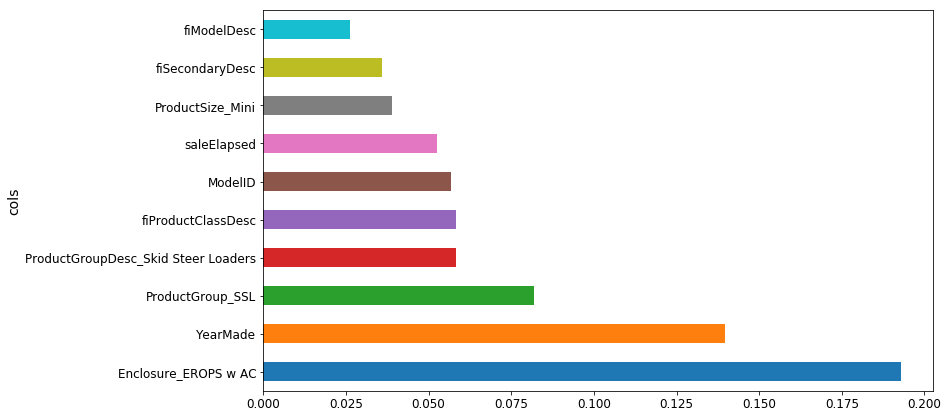

In [51]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

`YearMade` is the second most important.
We plot `Yearmade` against `saleElapsed` because it seems likely 
that they combine together to find how old was the product when it was sold.

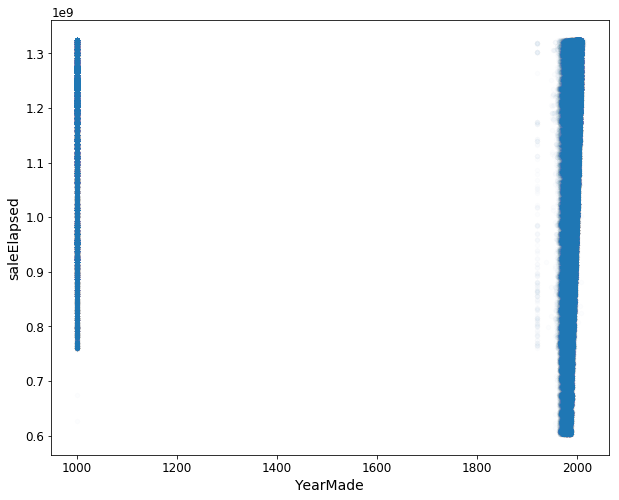

In [52]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

We get this ugly graph, which shows that `YearMade` has values that are 1000.
Now we ask the client and "...these bulldozers weren't actually made in the Year 1000... :)"
And they answe, yes they're ones where we don't know when it was made. 
Say, before 1986 we didn't track that, or things in Illinois we don't have that data provided, etc. 
There should be some reason to understand this plot better.

1000 is probably a given default values when the YearMade was unknown.  
Lets pick up a sample that only includes YearMade > 1930

In [53]:
from fastai.structured import get_sample
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

Let's now look at the relationship between `YearMade` and `SalePrice`.<br> 
[`GGplot`](http://ggplot.yhathq.com/) is the "grammar of graphics", recommended, powerful 
and flexible way of producing charts.
ggplot in python has the same parameters and API as the R version which is much better documented.

When we create plots, most datasets are going to be too big to plot: 
a scatter plot will create so many dots that it's just a big mess and take forever.
Don't put 10M samples when we only use 100K, can't see the pixels.
We called `get_sample` , 500 points for now.<br>
- `aes` stands for aesthetic, the basic way to set up columns in ggplot.
Plot these columns from this data frame.
- `+` plus means add chart elements.
Often  is hard to see what's going on a scatter plot because there's too much randomness.
A *smoother* creates a little linear regression for every little subset of the graph, 
it joins it up and allows you to see a nice smooth curve.

This is how we tend to look at univariate relationships.
By adding standard error `se=True` it also shows the confidence interval of this smoother.
`Loess` stands for Locally weighted regression, doing lots of little mini regressions.

the `loess` method below required to pip install scikit-misc

In [54]:
#!pip install scikit-misc

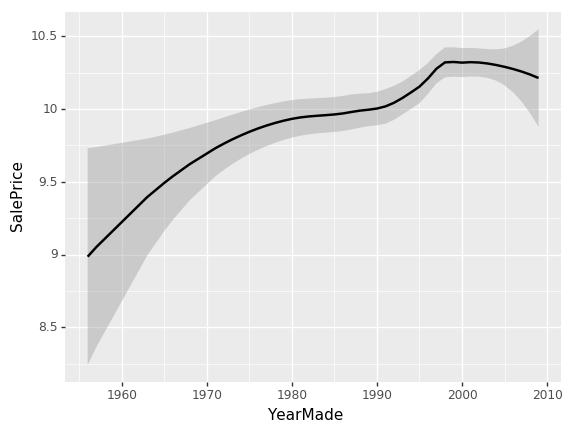

<ggplot: (8726353801834)>

In [55]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

We can see here the relationship between `YearMade` and `salePrice` 
Is a bit not really what we would expect, i.e., more recent stuff would be more expensive 
because of inflation and because there are more current models.<br>
The problem is that when we look at a univariate relationship like this
there's a lot of collinearity, a whole lot of interactions that are being lost.
For example, why did the price drop in some period 92-95? 
Is it because things made between 1992 and 1995 are less valuable, or because there was a recession then?
Maybe more people buying types of vehicle that were less expensive?

People will bring such univariate charts and say, *"our sales in Chicago have disappeared"* or
*"people aren't clicking on this add anymore"*.
They'll show a chart like this and ask *"what happened?"*
Most of the time, the answer to "what happened?" is that there's something else going on.
In Chicago last week we were doing a new promotion and that's why revenue went down.
It's not because people aren't buying stuff in Chicago, it's because the prices were lower.

We want to know what's the relationship between `salePrice` and `yearMade`, ceteris paribus. <br>
All other things being equal: if we sold something in 1990 versus 1980
and it was exactly the same thing, same person, the same option, 
what would have been the difference in price.
We use a **partial dependence plot** from the pdp library.

We take each of the 500 data points and make a little data set out of it.
Here's our data set of 500 options and the columns one of which is `yearMade`.
We're now going to create a chart where ceteris-paribus, in 1960, how much did bulldozers cost?
We replace the `YearMade` column with 1960, by copying the value 1960. 
Now in every row the `YearMade` is 1960 and all other data is the same.
We take the RF pass all this through to predict the sale price.
That will tell us for every $Z$ that was auctioned how much do we think it
would have been sold for if $Z$ was made in 1960.
And that's what we're going to plot at x=1960 in a graph, `YearMade` vs `SalePrice` 
(the partial-dependent).
Then we're going to do the same thing for 1961, etc.
Just passing a new year and seeing what it determines the price should be.
This is "like" the way we did feature importance,
but instead of randomly shuffling the column we replace the column with a constant value.
<br>
- Randomly shuffle the column tells us how accurate it is when you don't use that column anymore.
- Replacing the whole column with a constant tells us how much we would have sold that product
for in that auction on that day in that place if that product had been made in, e.g.,  1961

We take the average of all of the sale prices that we calculate from that RF and so we drew it for each year.

In [56]:
x = get_sample(X_train[X_train.YearMade>1930], 800)

In [57]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

The [partial dependence plot (pdp)](http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html) shows the marginal effect of a feature on the predicted outcome (J. H. Friedman 2001).  
A pdp can show if the relationship between the target and a feature is linear, monotonic or something else.
We calculate partial dependence by fixing the value of a column (eg `YearMade`), for each year (1960, 1961, ..., 2010). 
Then plot all the sample predictions for the values of `YearMade`. 
Yellow line is the average. Notice after 1990 is mostly a straight line.

This process tells us the relationship between `YearMade` and `SalePrice` ceteris paribus. 
A simplified approach would say what's the average auction, the average sale date
what's the most common type of machine we sell which location do we mostly sell things, etc.
We come up with a single row that represents the average option and
then we run that row through the RF but replace its `YearMade` with 1960.
And then do it again with 1961, 1962, ...
We plot those on our chart right, and that would give us a version of the
relationship between `YearMade` and `SalePrice`, ceteris paribus.
But what if tractors and backhoe loaders had different graphs?
Then taking the average would hide the fact that there are different relationships.
Instead we use what things we sell, who we sell them to, when we sell them, etc.
We actually find for every blue line actual examples of these relationships.
Then we can do a cluster analysis to find a few different shapes.
In this case they all look different versions of the same function,  with different slopes.
The takeaway is that the relationship between `SalePrice` and `YearMade` is basically a straight line.
NB: `SalePrice` is log of sale price, so it is showing an exponential.
Now bring in domain expertise, things depreciate over time by a constant ratio,
so we expect older stuff to have this exponential shape.

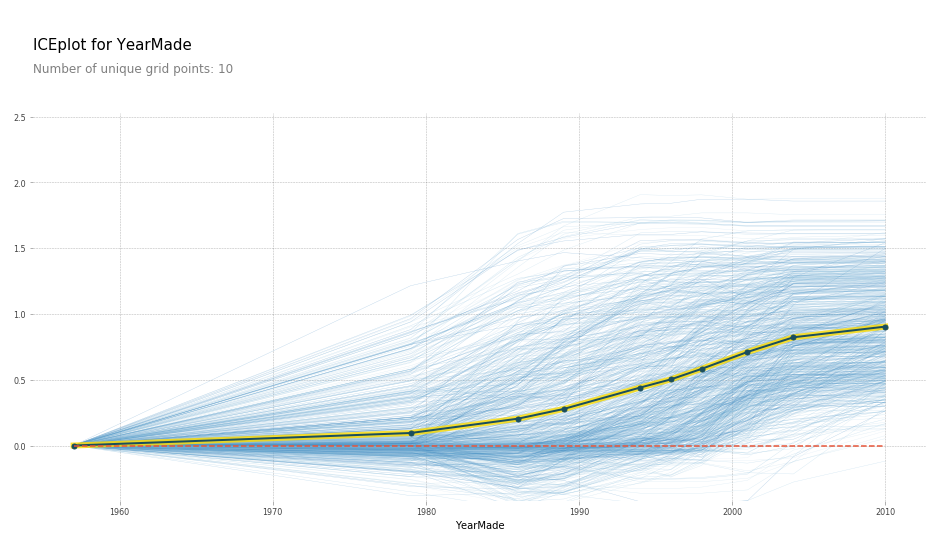

In [58]:
plot_pdp('YearMade')  

Each light blue lines is showing us all 500 points.
For row number 1 in our data set if we sold it in 1960, 1970, 1980, 1990, etc.
That particular auction would have been there if we sold it in that year.
So it plots all 500 predictions of how much every one of those 500 auctions
would have gone for if we replace `yearMade` with each of these different values.

The dark line is the average, tells us how much would we have
sold on average all of those options for if all of those products were actually
made in 1985 1990 1993 1994 and so forth.

For the period where we have reasonable data, ie since 1990,
it is a straight line which is what we would expect.
Because if it was sold the same (date, kind of tractor, to the same person in the same place), 
then we expect more recent vehicles to be more expensive because of inflation and because they're newer.
By removing all the externalities it often allows us to see the truth clearly.

The pdp is using a RF to get us a more clear interpretation of what's going on in our data.
We first look at the feature importance, then use pdp to tell us what's going on in average. 

Also, we can use cluster analysis to look at all 500 rows.
Do some of those rows move in the same way?
It seems many rows go down and then up, and some rows go up and then go flat.
So it does seem like there are different types of behaviors.
Below is the result of doing that cluster analysis.
We still get the same average but it shows the 5 most common shapes.
Here we can say for some kind of vehicle after 1990 their prices are pretty flat, 
and before that they were pretty linear.
And for some other kind of vehicle the opposite.
Different kinds of vehicle have different shapes.
We could dig into it. 

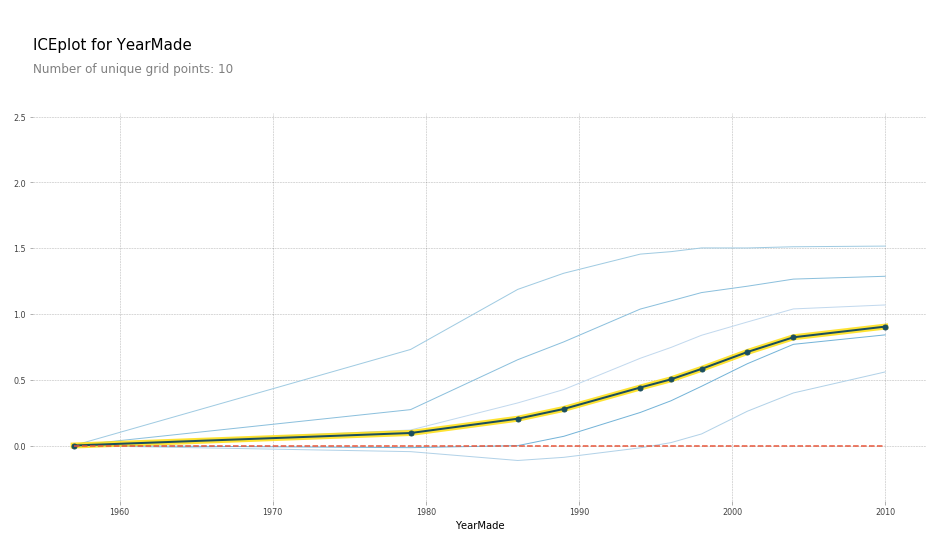

In [59]:
plot_pdp('YearMade', clusters=5)  # cluster the most common shapes we see...

The purpose of interpretation is to learn about a data set, to do something with it.
This is when we talk to somebody and we say there was this kind of dip in prices, 
based on things made between 1990 and 1997.
Or something else going on at that time.
<br>
Whatever business outcome we are trying to drive, this is how something's driving it.
If it is advertising technology, what's driving clicks, this is the variable that's driving it,
this is how it's related so therefore we should change our behavior in this way.
That's really the goal of any model.
<br>
There are 2 possible goals: 1. to get the predictions,
e.g., a hedge fund trader wants to know what the price of something is going to be;
an insurer wants to know how much claims someone will have.
<br>
Probably most of the time we're trying to change something
about how we do business: marketing, logistics, etc.
We care about how things are related to each other.

Q: bulldozers made in 2010 are not close to the type of bulldozers that were made in 1960.
Yet we are trying to just drop it to say oh if it was made in 1960... that may cause poor prediction?
<br>
A: Yes. It's a limitation of RFs is if we got a kind of data point that's not seen before.
For example, people didn't put AC in 1960 bulldozers.
We are saying how much would this bulldozer w/AC have gone for 1960...
We don't really have any information to know that.

It is a best technique, but it's not perfect.
We hope that the trees are still going to find some useful
truth even if though it hasn't seen that combination of features before.

At this point, JH suggests bringing in actual domain expertize to help interpret the data. After doing the feature importance, after all the above, is this the shape we expected?  We should have asked the question `what shape will be expect` before starting. The pdp graph shows the truth...

On how many features should we do pdp?  On all the important ones, particularly if they are **levers**, e.g. something we can change.

how do `saleElapsed` and `YearMade` together impact price?
If we do a PDP interaction plot it shows in separate graphs (vs price):
`saleElapsed`, `yearmade`, and the combination. <br>
(remember this is always log of price that's why the prices look weird)

Below we can see that the combination of `saleElapsed` and `yearmade`, later dates have the higher prices: those where there's the least `saleElapsed` and the most recent `yearMade`.
The graphs show:
- the univariate relationship between `saleElapsed` and price 
- the univariate relationship between `yearmade` and price, 
- and the combination of the two.

It's enough to see clearly that these two things are driving price together.
We can also see these are not simple diagonal lines so it's some interesting interaction going on.
Based on looking at these plots motivates to put in some kind of interaction term and see what happens.

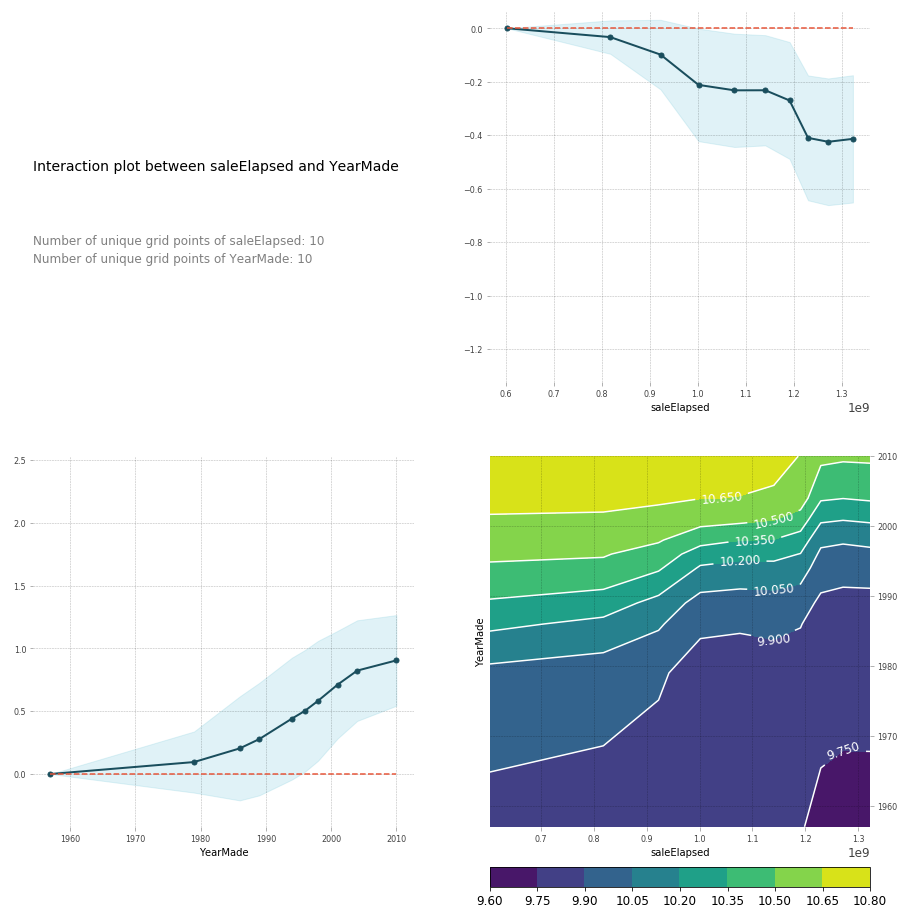

In [60]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

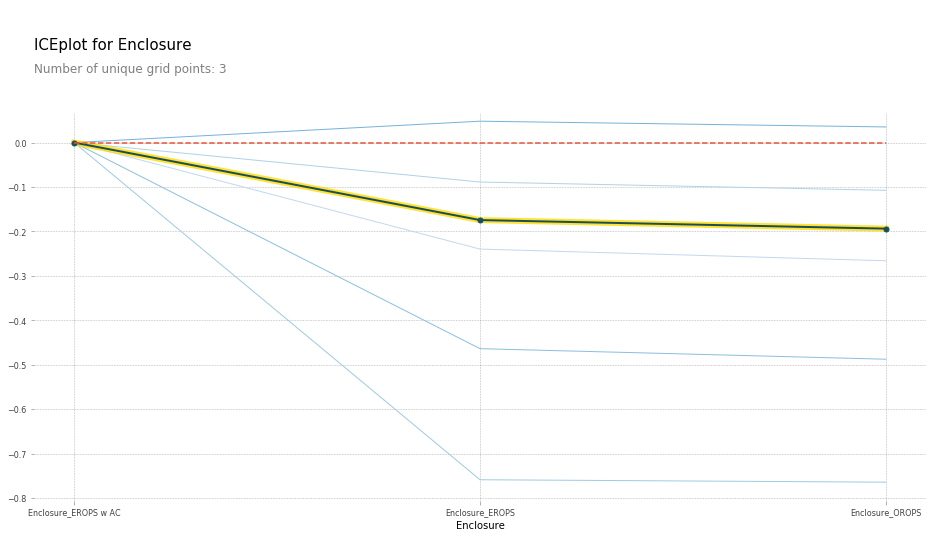

In [61]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

We did one hot encoding at the top and got several variables like `Enclosure_EROPS w AC`.
We can pass an array of them to plot_pdp and it'll treat them as a category.
Above we create a PDP plot of these 3 categories and call it Enclosure.
`Enclosure_EROPS w AC` on average are more expensive than the other 2 which looks similar.<br>
Now we Google these to find out what these things are.
`EROPS` is enclosed rollover protective structure.
If the bulldozer is fully enclosed then optionally you can get AC.
Ceteris paribus, the same bulldozer sold at the same time,
built at the same time sold to the same person is going to be
quite a bit more expensive is if it has air conditioning than if it doesn't.

Compute the age for each item.

In [62]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950   # avoid missing values
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

Tried first of all setting everything before 1950 to 1950 (it seems to be some kind of missing value).
We set age to be equal to `saleYear - YearMade`.
Then we run a RF on that, and indeed `age` is now the single biggest thing.<br>
We used this to find an interaction but a RF can create an interaction through having
multiple split points.
So we shouldn't assume that this is actually going to be a better result.
We actually found the score and rmse adding age was actually a little worse.  

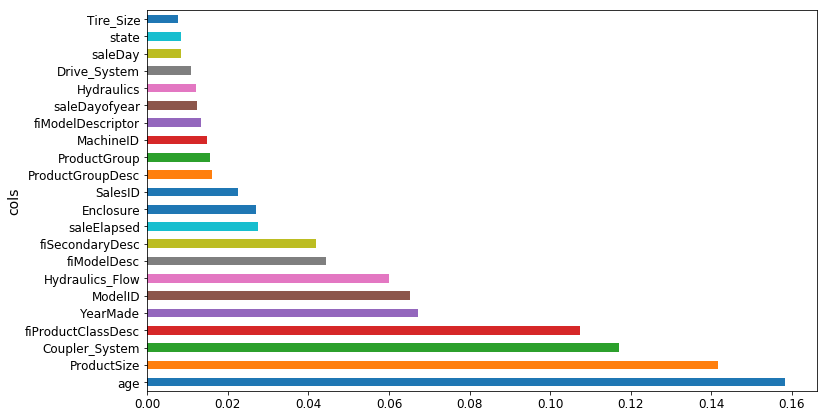

In [63]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

Now clearly age is the most important

#  Tree interpreter

Very important. For example, an insurance company may need to justify the increase in cost of a policy.
Given a model prediction, when somebody asks why, we can use **tree interpreter**. 
It allows us to take a particular row, e.g. row number zero.
<br>
Tree interpreter will gives back:
- predictions from the RF
- bias the average sale price across the whole original data set.
- contributions.
<br>
At all decision points we're adding or subtracting a bit from the value.
So for all the trees, we take the average so every time we see a variable value, 
did we increase or decrease the value and by how much.
We take the average of all of those and that's what ends up in `contributions`.<br>
Below are all the predictors and the value of each.

`treeinterpreter` is a package for interpreting scikit-learn's decision tree and RF predictions. 
Allows decomposing each prediction into bias and feature contribution components as described in this [blog](http://blog.datadive.net/interpreting-random-forests/). 
For a dataset with n features, each prediction on the dataset is decomposed as <br>
prediction = bias + feature_1_contribution + ... + feature_n_contribution.

In [64]:
#!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti    #Requires pip install treeinterpreter

In [65]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

We pick up **a row**, and interpret **why** the predictions are like they are (eg why the price is what it is, why is a patient going to be readmitted to the hospital, etc.) <br>
Below are all what we know about a particular row.

In [95]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,          0,       3232,          4,          0,          4,          0,         16,
                35,         12,         11]])

`ti.predict`(model, X, joint_contribution=False) given a particular instance (eg a quote for insurance)<br>
Returns a triple (prediction, bias, feature_contributions), such that prediction ≈ bias + feature_contribution <br>
(`bias` is the root of the tree, the average price for everybody, `contributions` is how important is each of the variables)

In [102]:
prediction, bias, contributions = ti.predict(m, row) 

prediction[0], bias[0]   # For row 0, the predicted price and the average (bias) price.

(9.135812394522567, 10.105476745893043)

`np.argsort`(a, axis=-1, kind='quicksort', order=None) <br>
Returns the indices that would sort an array.
Tells us where each item would move to if it were sorted.

Analysis with the drawing of the simple tree:
If we look at a single tree, at the top of a tree, before any split.
10.189 is the average log price of all of the options in the training set.
For `Coupler_System $<= 0.5$` we get 10.345 (for the subset of 16,800).
For those, we then take the subset with `Enclosure $<= 2.0$` and we get 9.955 average sale price.
The final step, `ModelID $<= 4573.0$` and that gives us 10.226. 
Starting with 10.189 average for all in our training set for this particular tree subsample 20000,
adding the firt decision changes it to 10.345.
Hence, the `Coupler` variable is responsible for a (.156 = .345 - .189)  increase in a prediction,
`Enclosure` decreased it by .395, and ModelID increased it by .276. 

In [103]:
idxs = np.argsort(contributions[0])   

Below are the sorted contributions for row=0 in triples:
(variables, actual values, contributions). <br>
By passing `idxs` to each one of the columns, we can print out all in the right order.

In [104]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5663753800819199),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.18568636334551192),
 ('state', 'Ohio', -0.14658346628599792),
 ('fiModelDesc', 'KX1212', -0.12138659291772047),
 ('fiSecondaryDesc', nan, -0.06036455424760613),
 ('Enclosure', 'EROPS', -0.036274934618695714),
 ('fiModelDescriptor', nan, -0.029262714242421446),
 ('saleElapsed', 1284595200, -0.020726196215251343),
 ('Drive_System', nan, -0.013106805010636564),
 ('Tire_Size', nan, -0.005763702007854121),
 ('saleDay', 16, 0.0023839387829326006),
 ('SalesID', 4364751, 0.006154106605236552),
 ('MachineID', 2300944, 0.00659933208280798),
 ('ProductGroup', 'TEX', 0.012184093075801537),
 ('ProductGroupDesc', 'Track Excavators', 0.012381932577066962),
 ('ModelID', 665, 0.027261612914913188),
 ('Hydraulics_Flow', nan, 0.028962676238882264),
 ('Coupler_System', nan, 0.049130351864416465),
 ('YearMade', 1999, 0.07080831346108057)]

In [105]:
contributions[0].sum()   # sum all contributions together

-0.9696643513704775

### Waterfall
[Waterfall tool](https://github.com/chrispaulca/waterfall)
We can draw a **waterfall block**, a most useful plot.
For a RF we can do that across all of the trees, 
combine them all together we get what tree interpreter does. <br>
We can use this to explain a prediction, eg., you are going to like this movie because 
you're this age range, gender, people like you did like that movie.
<br>
**This is an unknown technique and library.**
ML models are interpretable. 
In contrast, trying to do that with a linear model is hard.

In [93]:
#!pip install waterfallcharts
import waterfall_chart

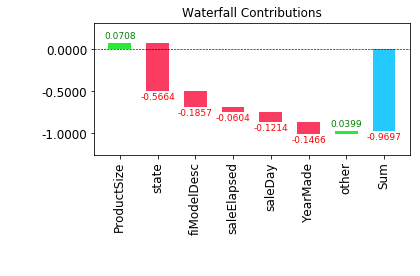

In [126]:
colnames = df_keep.columns[idxs].values
contribs = [contributions[0][i] for i in range(len(contributions[0]))]
assert(len(contribs) == len(colnames))
my_plot=waterfall_chart.plot(colnames,contribs, Title="Waterfall Contributions",
                             rotation_value=90, threshold=0.1 ,formatting='{:,.4f}', net_label="Sum")

# Extrapolation

Problem: RF can't *extrapolate* a linear time relationship...<br>
We want to avoid using time variables as predictors if there is an alternative that can work better in the future.<br>
What is the difference between validation and training sets? 
If we understand this difference we can know which predictors have a strong temporal component 
and hence will be less relevant in the future.<br>
So we create a **new RF where the dependent variable is "is it in the validation set"**. 
Great trick in Kaggle to see if we can predict the test set...

In [75]:
df_ext = df_keep.copy()   #make a copy of the original DF
df_ext['is_valid'] = 1    # Add column (variable) for rows in validation set and assign 1
df_ext.is_valid[:n_trn] = 0 # zero the column for rows in training set
x, y, nas = proc_df(df_ext, 'is_valid')  #use it as a dependent variable

Below RF does not predict price, it predicts is this in the validation set or not.
If our variables were not time dependent, then it shouldn't be possible to figure out
if something's in the validation set or not.
This is a great trick (eg in kaggle), when they won't tell you if the test set is a random sample or not.
So we can put the test set and the training set together,
create a new column called `is_test` and see if we can predict it.
If we can predict it, then the test set is not a random sample.
That means we have to create a validation set from it.

In [76]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999950140230601

This is not a random sample because my validation sample can be predicted with a .9999 $R^2$

Now we look at feature importance.
`SalesID` is the top, so it is not a random identifier.
Likely it is set consecutively, as time goes on they increase the `salesID`.
`saleElapsed` was the number of days since the first date in the data set, and also is a good predictor.
`machineID` also, as machines are labeled with some consecutive identifier.

In [77]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.810870
5,saleElapsed,0.131450
12,MachineID,0.045623
19,saleDayofyear,0.004838
10,fiModelDesc,0.002213
4,ModelID,0.001533
0,YearMade,0.001287
1,Coupler_System,0.000930
20,Hydraulics,0.000473
8,Enclosure,0.000268


Notice that `SalesID` is the most important, meaning that it has a strong temporal component, ie., SalesID increases over time.  `saleElapsed` also a good predictor.  Lets choose only the top 3 ('SalesID', 'saleElapsed', 'MachineID') as they are the only ones that are above .01 

In [78]:
feats=['SalesID', 'saleElapsed', 'MachineID']

lets take a look at values of these both in Train set and Validation set to confirm our suspicion.

In [79]:
(X_train[feats]/1000).describe()  

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [80]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


For example, `salesID` averages 1.8 million in the training set and 5.8 million in the validation set.
<br>
Clearly they are temporal, eg higher in validation... so lets drop them.

In [81]:
x.drop(feats, axis=1, inplace=True)

Let's now see if we can still predict whether something's in the validation set... 

In [82]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9787298223745715

Improvement from .9999 but still bad, as we can still predict the validation set. <br> 
So now lets see which other variables are the most important.

In [83]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.231181
0,YearMade,0.181376
16,saleDayofyear,0.162434
4,ModelID,0.079884
9,fiModelDesc,0.062901
14,saleDay,0.060272
15,state,0.055321
3,fiProductClassDesc,0.033418
6,fiSecondaryDesc,0.025271
7,Enclosure,0.021850


Once we remove some variables, others can come to the front.
Now `age`, as older things are more likely to be in the validation set.
We try removing those as well.

In [84]:
set_rf_samples(50000)

We can then take all time dependent features.
We still want them in the RF if they're important.
But if they're not important, then taking them out 
if there are other long-term dependent variables that work well would be better.
We are going to have a model that generalizes over time better.

In [85]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

Lets redo the RF to get a base reference point of R2 valid and OOB.

In [86]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.2077550545100053, 0.24820064739262776, 0.9097934603830179, 0.8899845210238743, 0.8932281801901086]


Now lets try to remove each of the top feats, one by one and see how we do.
Below we go through each one of the features and drop one at a time.
We retrain a new RF and print out the score.

In [87]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20869683241170287, 0.2451238344313283, 0.9089737731779199, 0.8926952227902113, 0.8928961625733637]
saleElapsed
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.21419185305859606, 0.25409591995059216, 0.9041171968321756, 0.8846962698680747, 0.887128570295602]
MachineID
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.206759017465641, 0.24515967013188703, 0.9106563387789541, 0.8926638458092089, 0.8950735962836368]
age
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.2090923435492623, 0.24759005411344157, 0.9086284301218512, 0.8905251488200884, 0.892119272074683]
YearMade
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.2085664196895231, 0.25097610380996427, 0.9090875005293152, 0.8875103100076585, 0.8926884374171948]
saleDayofyear
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20863608866108063, 0.24514846487581599, 0.909026754046647, 0.8926736573871638, 0.8930213690669]


So we see that for 3 variables (`SalesID`, `MachineID`, `saleDayofyear`) the `$R^2$ valid` got better. 
Therefore, lets try to remove them and see how it affects.

In [88]:
reset_rf_samples()

In [89]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.13862934403302335, 0.21826561350075366, 0.9598352412622646, 0.9149217369197117, 0.9091137390350393]


$R^2$ valid got better! from .890 to .914, and, as expected $R^2$ validation was better that OOB.
We've got rid of 3 time dependent variables and now validation is better than OOB. <br>
Now we check feature importance and it is good.

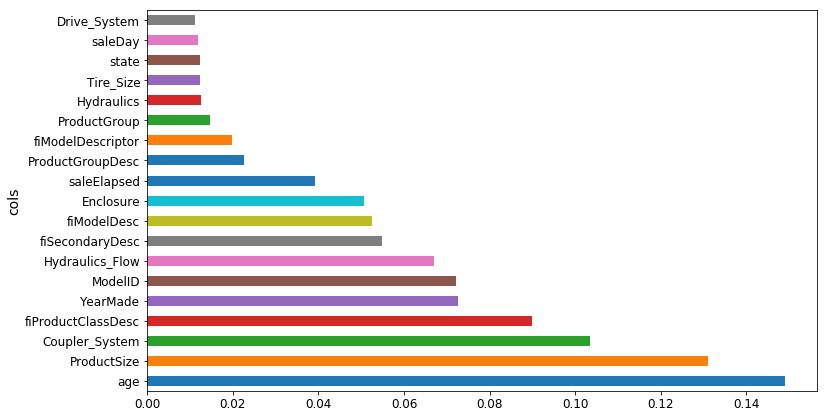

In [90]:
plot_fi(rf_feat_importance(m, X_train));

In [91]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

Now lets try to do it with more (180) trees, etc.

In [92]:
m = RandomForestRegressor(n_estimators=180, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 28s, sys: 2.07 s, total: 5min 30s
Wall time: 35.6 s
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.08005612179474758, 0.2105218833878011, 0.9866055797413831, 0.9208515403305337, 0.9147544495980792]


We did all the interpretation and fine-tuning with smaller models subsets.
And at the end we run the whole thing in less than 40 seconds, and got an RMSE valid of 0.211,
which is better (lower) that the Leaderboard Kaggle champion which was .21796.
This was a genuine real-world modeling process we can use and it gives world-class results.

# END